In [2]:
using JuMP, HiGHS
using Plots;
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
include("../src/utils.jl")
ENV["COLUMNS"]=120;

gen_df, gen_var_long, loads_long, network = process_data("../WECC")

zone_dict = Dict(zip(gen_df.zone, gen_df.zone_name));
line_dict = Dict(zip(network.network_lines, network."transmission path name"));

In [3]:
include("../src/unit_commitments.jl")

# A spring day
n=100
T_period = (n*24+6):(n*24+30)

# gen_df = gen_df[gen_df.r_id .!= 119, :]

# gen_df = gen_df[gen_df.technology .!= "Conventional Hydroelectric", :]
loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]

gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]

solution = uc_with_transport(
    gen_df, loads_multi, gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 51324 rows; 27300 cols; 153375 nonzeros; 10425 integer variables (10425 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [1e+00, 3e+04]
Presolving model
36965 rows, 26870 cols, 132488 nonzeros  0s
28077 rows, 21432 cols, 114718 nonzeros  0s
20849 rows, 19722 cols, 104541 nonzeros  0s
17632 rows, 16812 cols, 99758 nonzeros  1s
16093 rows, 15376 cols, 95231 nonzeros  3s

Solving MIP model with:
   16093 rows
   15376 cols (8838 binary, 0 integer, 0 implied int., 6538 continuous, 0 domain fixed)
   95231 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u =

In [4]:
# stop halfway through
recommit_time = 12
initial_time = n*24+6
final_time = n*24+30
T_period = (initial_time + recommit_time):(final_time)

# gen_df = gen_df[gen_df.r_id .!= 119, :]

# gen_df = gen_df[gen_df.technology .!= "Conventional Hydroelectric", :]
loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]

ruc_gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]

gen_vre = gen_df[gen_df[!,:vre] .== 1, :r_id]
mask = in.(ruc_gen_var_multi.r_id, Ref(gen_vre))
ruc_gen_var_multi[mask, :cf] .*= 1.5 # it's real sunny ! and windy !

ruc_solution = reliability_uc(
    solution.decision_vars, n*24+6 + recommit_time,
    gen_df, loads_multi, ruc_gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 26705 rows; 14196 cols; 74384 nonzeros; 5421 integer variables (3540 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [2e-14, 3e+04]
Presolving model
14326 rows, 10932 cols, 43802 nonzeros  0s
9415 rows, 7728 cols, 33806 nonzeros  0s
6800 rows, 7069 cols, 29803 nonzeros  0s
5489 rows, 6136 cols, 27290 nonzeros  0s
4577 rows, 5291 cols, 25503 nonzeros  0s
4184 rows, 5102 cols, 23888 nonzeros  0s

Solving MIP model with:
   4184 rows
   5102 cols (2264 binary, 0 integer, 0 implied int., 2838 continuous, 0 domain fixed)
   23888 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero

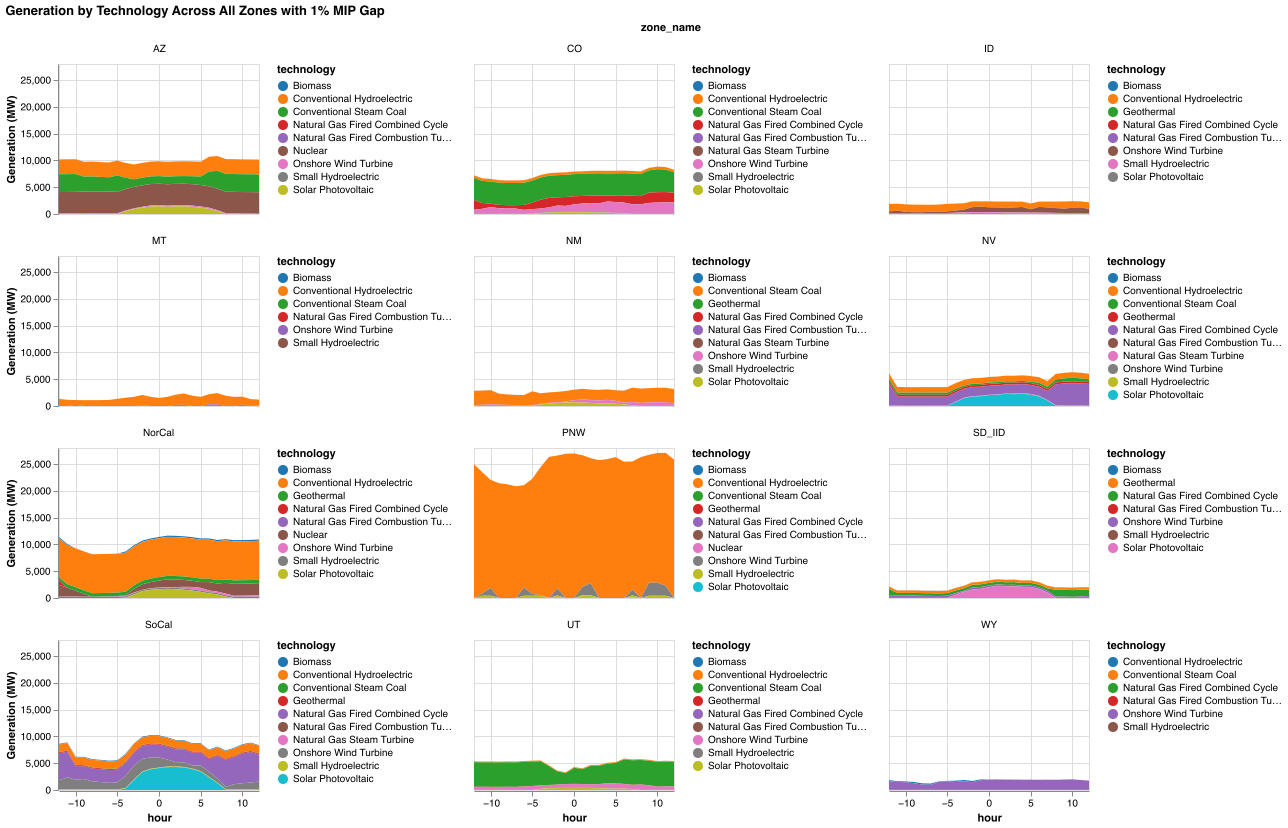

In [5]:
include("../src/plots.jl")
sol_gen_zone = plot_generation_by_zone(
    solution, T_period, gen_df, zone_dict,
    "Generation by Technology Across All Zones with 1% MIP Gap"
    );

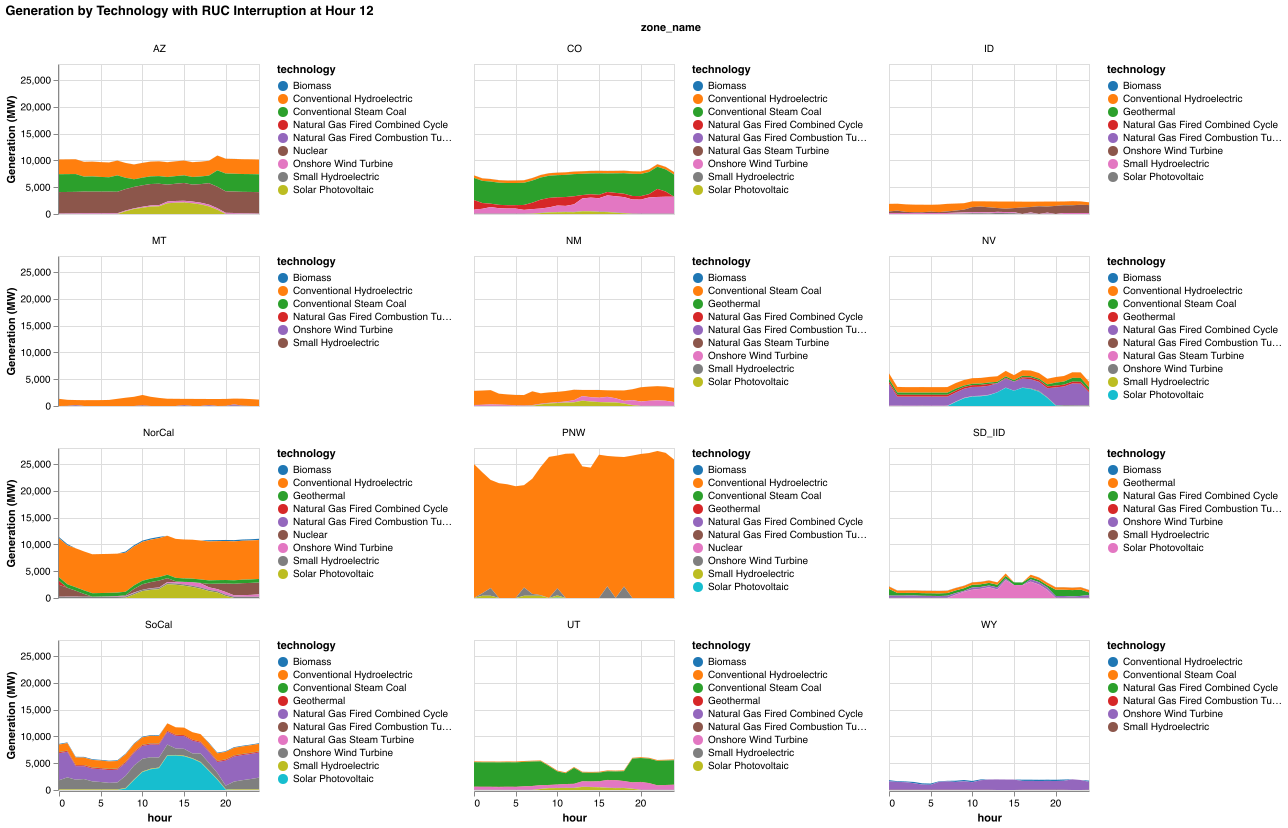

In [6]:
combined_gen_zone = plot_ruc_generation_by_zone(
    solution, ruc_solution, initial_time, recommit_time,
    gen_df, zone_dict,
    "Generation by Technology Across All Zones with RUC at Hour $recommit_time"
    );

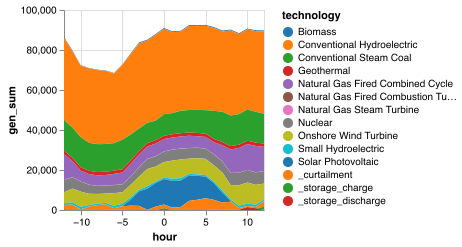

In [7]:
sol_gen = plot_total_generation(
    solution, T_period,
    gen_df, zone_dict,
    "Generation with RUC Interruption at Hour $(recommit_time)"
    );

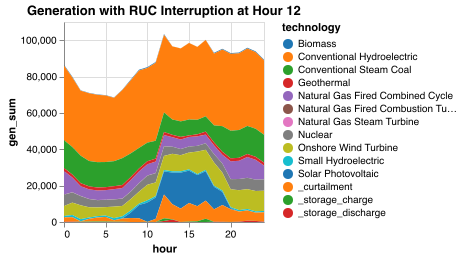

In [8]:
combined_gen = plot_total_ruc_generation(
    solution, ruc_solution, initial_time, recommit_time,
    gen_df, zone_dict,
    "Generation with RUC Interruption at Hour $(recommit_time)"
    );

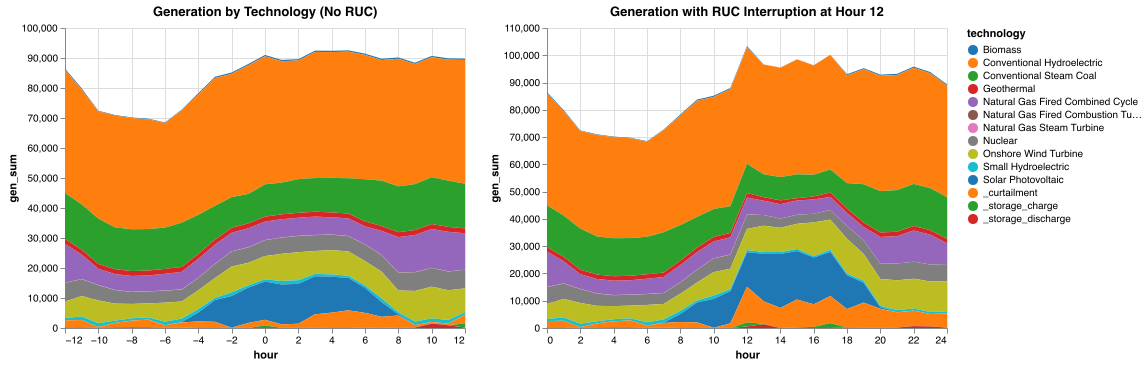

In [9]:
# Side-by-side (unfair) comparison of original vs RUC solutions
# original does not account for perturbed forecast
@vlplot(
    hconcat = [
        {
            data = sol_gen,
            mark = :area,
            encoding = {
                x = {field = :hour, type = "quantitative"},
                y = {field = :gen_sum, type = "quantitative", stack = :zero},
                color = {field = "technology", type = "nominal", scale = {scheme = "category10"}}
            },
            title = "Generation by Technology (No RUC)",
            width = 400, 
            height = 300
        },
        {
            data = combined_gen,
            mark = :area,
            encoding = {
                x = {field = :hour, type = "quantitative"},
                y = {field = :gen_sum, type = "quantitative", stack = :zero},
                color = {field = "technology", type = "nominal", scale = {scheme = "category10"}}
            },
            title = "Generation with RUC Interruption at Hour $(recommit_time)",
            width = 400, 
            height = 300
        }
    ]
)

In [10]:
include("../src/network_analysis.jl")
plots_dir = "power_flow_plots"
if !isdir(plots_dir)
    mkpath(plots_dir)
end

plot_power_network(
    solution.flows,
    network,
    gen_df,
    zone_dict;
    hour=2418,
    save_path=joinpath(plots_dir, "network_hour_2418.png")
)

animate_power_network(
    solution.flows,
    network,
    gen_df,
    zone_dict;
    hours=2406:2430,
    save_path=joinpath(plots_dir, "network_animation.gif")
)

plot_flow_heatmap(
    solution.flows,
    network,
    line_dict;
    save_path=joinpath(plots_dir, "flow_heatmap.png")
)

compare_network_flows(
    solution.flows,
    ruc_solution.flows,
    network,
    gen_df,
    zone_dict;
    hour=2418,
    save_path=joinpath(plots_dir, "flow_comparison.png")
)

plot_congestion_analysis(
    solution.flows,
    network;
    save_path=joinpath(plots_dir, "congestion_analysis.png")
)

[ Info: Saved animation to /Users/eddiek/Documents/GitHub/intraday-commitments/model_notebooks/power_flow_plots/network_animation.gif


Animation saved to power_flow_plots/network_animation.gif


Row,line,max_capacity,avg_flow,peak_flow,utilization,hours_congested
,Int64,Float64,Float64,Float64,Float64,Int64
1,5,2858.0,2858.0,2858.0,1.0,25
2,2,4200.0,4138.88,4200.0,1.0,24
3,21,250.0,184.431,250.0,1.0,17
4,8,1920.0,1551.55,1920.0,1.0,16
5,19,500.0,299.917,500.0,1.0,14
6,3,100.0,12.1423,100.0,1.0,3
7,23,664.0,106.923,664.0,1.0,3
8,13,325.0,38.9486,325.0,1.0,2
9,22,350.0,134.449,350.0,1.0,2
